# Universe Evolution from the Friedmann equations

# Friedmann Equations

The equations are
$$ \left( \frac{\dot a}{a} \right)^2 = \frac{8 \pi G}{3} \rho - \frac{kc^2}{a^2}$$  
$$ \dot\rho_i =  -3\frac{\dot a}{a}\left(\rho_i+\frac{P_i}{c^2}\right) $$ 
This can be rewritten using  $$ p(t) = p_0 \left( \frac{a}{a_0} \right) ^{-3(1+w)}$$
using the ratio $$ \Omega=\frac{\rho}{\rho_c}= \rho \frac{8 \pi G}{3H^2} $$ 
and
$$\Omega-1=\frac{kc^2}{H^2a^2}=\Omega_k$$
If $\Omega_k$ is not zero, his value fixes $a_0$ and $k$. But in the following process we can set $a_0=1$ to find $\frac{a(t)}{a_0}$
$$ \left( \frac{\dot a}{a} \right)^2 = H_0^2 (\Omega_ma^{-3} + \Omega_r a^{-4} + \Omega_\Lambda- \Omega_k a^{-2}) $$ 

# But
Using the first equation has solution $\dot a = \pm ...$ that is a problem if $\dot a$ changes sign (close, m-dominated universe), so the second and third Friedmann equations will be used
$$ \frac{\ddot a}{a} = -\frac{4 \pi G}{3}\left(\rho+3\frac{P}{c^2}\right) $$
And using the second one and the rescaling, we obtain 
$$ \frac{\ddot a}{a} = -\frac{H_0^2}{2}[(1+3w_i)\rho_i a^{-3(1+w_i)}] $$
The results are the same, and there is no need to calculate $\Omega_k$


# Universe class
This class contains the parameters of the universe to be simulated. The evolution is decided by the present Hubble parameter $H_0$ and the energy density ratio $\Omega_i$ in respect to the critical energy density $\rho_c$ for a flat universe.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
G = 6.6743e-11 #G in SI
c =  299792458 #G in SI
H0 = 2.27e-18 #Hubble constant in Si units
Mpc = 3.085677581e22 #Mpc in Meters

In [3]:

critical_density = lambda H : 3*H**2/(8*np.pi*G)  #Get the critical density for a flat universe, using the present Hubble value
second2Gyear = lambda t: t/(3600*24*365.25*1e9)   #Seconds to Gigayears conversion
Gyear2second = lambda t: t*(3600*24*365.25*1e9)   #Gigayears to secondsconversion
Hubble2SI = lambda H : H*1e3/Mpc  #Hubble constant from km/(s*Mpc) to SI units

In [4]:
class universe:

  def __init__(self,H0, Omega0, time_span=(-100,100)):
    
    #Reading the values
    
    self.Omega0 = Omega0                    #present day energy density    
    self.H0_kmsMpc = H0                     #present day Hubble parameter
    self.H0 = Hubble2SI(H0)                 #Conversion in SI units
    self.time_span = time_span              #time span of the universe to be simulated
    
    self.Omega0_k = self.Omega0['m']+self.Omega0['r']+self.Omega0['L']-1  #curvature energy density
    self.k = 0 if self.Omega0_k==0 else 1 if self.Omega0_k>0 else -1      #curvature paramter
    
    self.T, self.a, self.H = self.evolution(time_span[0], time_span[1])   #evolve the universe
    
    Omega = {'m': self.Omega0['m']*self.a**-3, 'r': self.Omega0['r']*self.a**-4, 'L': self.Omega0['L'], 'k': self.Omega0_k*self.a**-2}  #energy density during the evolution
    Omega_tot = sum(Omega[i] for i in Omega)  #total energy density
    self.Omega = {i: Omega[i]/Omega_tot for i in Omega}
    
    print(self)
    
  def __str__(self):  #String associated to the class that will be printed when calling print(universe)
    curvature = 'flat' if self.k==0 else 'open' if self.k==-1 else 'close'
    s = f'Universe with a present Hubble parameter of {self.H0_kmsMpc} km/(s Mpc).\n\
    The critical energy density is {critical_density(self.H0):.4e}, the present one has components {self.Omega0}.\n\
    The universe is {curvature} (k = {self.k}), with curvature energy density {self.Omega0_k:.4e}.'
    return s
  
  def f(self, t, y, H0, Omega0):
    return [y[1], -0.5*y[0]*H0**2*(Omega0['m']*y[0]**-3 + 2*Omega0['r']*y[0]**-4 - 2*Omega0['L'])]
  
  #def z(self, t)

  def eventAttr():  #decorator needed to set terminal=True in the event finder
    def decorator(func):
        func.terminal = True
        return func
    return decorator

  @eventAttr()
  def singularity(self, t, y, H0, Omega0): return y[0] #Stop the evolution if a singularity (a=0) is found
  
  def evolution(self, t_past, t_future):
    
    t_lims = [Gyear2second(t_past), Gyear2second(t_future)]
    #Past evolution
    Y_past = solve_ivp(self.f, (0, t_lims[0]), y0=[1.0, self.H0], method='RK45', t_eval=np.linspace(0, t_lims[0],  10000), events = self.singularity, args=(self.H0, self.Omega0), rtol=1e-10)
    
    if len(Y_past.t_events[0])>0:
      self.TBB = second2Gyear(Y_past.t_events[0][0])
      print(f'Big Bang happened {self.TBB:.3f} Gyr from now')
    
    #Future evolution
    Y_future = solve_ivp(self.f, (0, t_lims[1]), y0=[1.0, self.H0], method='RK45', t_eval=np.linspace(0, t_lims[1],  10000), events = self.singularity, args=(self.H0, self.Omega0), rtol=1e-10)
    if len(Y_future.t_events[0])>0:
      print(f'Big Crunch is gonna happen {second2Gyear(Y_future.t_events[0][0]):.3f} Gyr from now')
    
    #Appending the two solutions (the start point is duplicated, but it should not be a problem) 
    
    T = np.append(np.flip(np.array(Y_past.t)), np.array(Y_future.t))
    a = np.append(np.flip(np.array(Y_past.y[0])), np.array(Y_future.y[0]))
    a_dot = np.array(np.append(np.flip(np.array(Y_past.y[1])), np.array(Y_future.y[1])))   
    
    H = a_dot/a
    return second2Gyear(T), a, H

  

Big Bang happened -13.770 Gyr from now
Universe with a present Hubble parameter of 67.4 km/(s Mpc).
    The critical energy density is 8.5329e-27, the present one has components {'m': 0.315, 'r': 2.3e-05, 'L': 0.679}.
    The universe is open (k = -1), with curvature energy density -5.9770e-03.


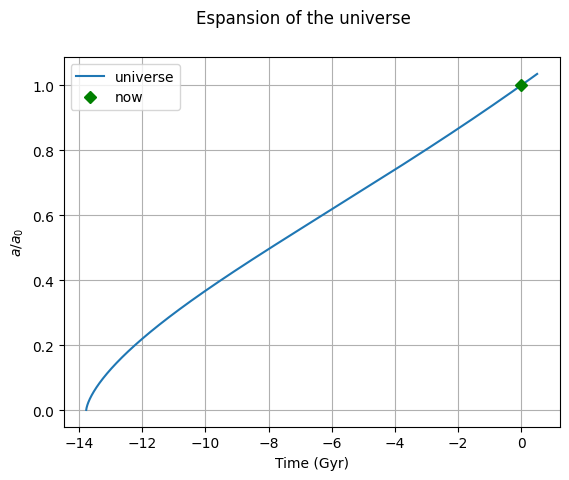

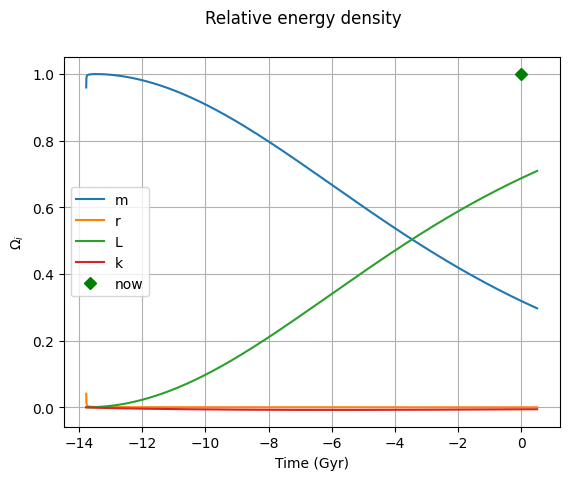

In [5]:
u = universe(67.4, {'m':0.315, 'r':2.3e-5, 'L': 0.679}, time_span=(-30,0.5))

fig, ax = plt.subplots()
fig.suptitle('Espansion of the universe')
ax.grid()
ax.plot(u.T,u.a, label = 'universe')
ax.plot(0.0, 1.0, 'gD', label = 'now')
ax.set_xlabel('Time (Gyr)')
ax.set_ylabel('$ a/a_0 $')
ax.legend()
plt.show()

fig, ax = plt.subplots()
fig.suptitle('Relative energy density')
ax.grid()
for i in u.Omega: ax.plot(u.T, u.Omega[i], label = i)

ax.plot(0.0, 1.0, 'gD', label = 'now')
ax.set_xlabel('Time (Gyr)')
ax.set_ylabel('$ \Omega_i $')
ax.legend()
plt.show()

Radiation domination is not visible because it happens very quickly at the beginning and so is not integrated by the finite size steps chosen by the integrator

Big Bang happened -9.672 Gyr from now
Universe with a present Hubble parameter of 67.4 km/(s Mpc).
    The critical energy density is 8.5329e-27, the present one has components {'m': 1.0, 'r': 0, 'L': 0}.
    The universe is flat (k = 0), with curvature energy density 0.0000e+00.
Big Bang happened -9.486 Gyr from now
Big Crunch is gonna happen 1575.874 Gyr from now
Universe with a present Hubble parameter of 67.4 km/(s Mpc).
    The critical energy density is 8.5329e-27, the present one has components {'m': 1.1, 'r': 0, 'L': 0}.
    The universe is close (k = 1), with curvature energy density 1.0000e-01.
Big Bang happened -9.874 Gyr from now
Universe with a present Hubble parameter of 67.4 km/(s Mpc).
    The critical energy density is 8.5329e-27, the present one has components {'m': 0.9, 'r': 0, 'L': 0}.
    The universe is open (k = -1), with curvature energy density -1.0000e-01.


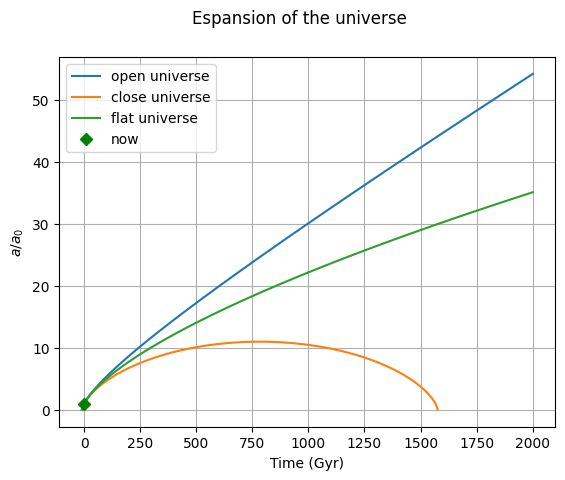

In [9]:
flat = universe(67.4, {'m':1.0, 'r':0, 'L': 0}, time_span=(-30,2e3))
close = universe(67.4, {'m':1.1, 'r':0, 'L': 0}, time_span=(-30,2e3))
open = universe(67.4, {'m':0.9, 'r':0, 'L': 0}, time_span=(-30,2e3))

fig, ax = plt.subplots()
fig.suptitle('Espansion of the universe')
ax.grid()
ax.plot(open.T,open.a, label = 'open universe')
ax.plot(close.T,close.a, label = 'close universe')
ax.plot(flat.T, flat.a, label = 'flat universe')
ax.plot(0.0, 1.0, 'gD', label = 'now')
ax.set_xlabel('Time (Gyr)')
ax.set_ylabel('$ a/a_0 $')
ax.legend()
plt.show()

Big Bang happened -19.032 Gyr from now
Universe with a present Hubble parameter of 50 km/(s Mpc).
    The critical energy density is 4.6959e-27, the present one has components {'m': 0.29, 'r': 1e-05, 'L': 0.71}.
    The universe is close (k = 1), with curvature energy density 1.0000e-05.
Big Bang happened -13.594 Gyr from now
Universe with a present Hubble parameter of 70 km/(s Mpc).
    The critical energy density is 9.2039e-27, the present one has components {'m': 0.29, 'r': 1e-05, 'L': 0.71}.
    The universe is close (k = 1), with curvature energy density 1.0000e-05.
Big Bang happened -9.516 Gyr from now
Universe with a present Hubble parameter of 100 km/(s Mpc).
    The critical energy density is 1.8783e-26, the present one has components {'m': 0.29, 'r': 1e-05, 'L': 0.71}.
    The universe is close (k = 1), with curvature energy density 1.0000e-05.


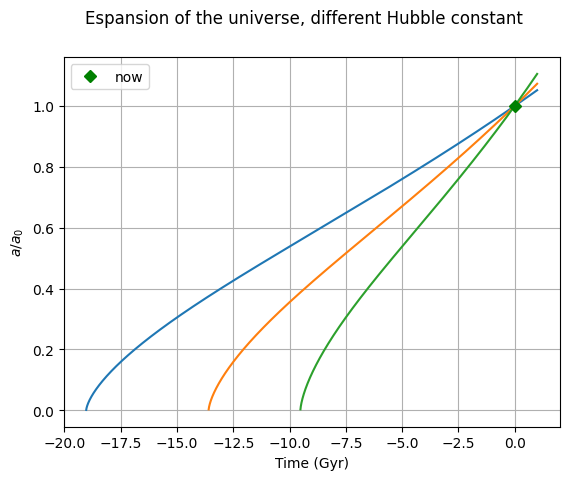

In [14]:
l = [universe(i, {'m':0.29, 'r':1e-5, 'L': 0.71}, time_span=(-30,1)) for i in [50,70,100]]

fig, ax = plt.subplots()
fig.suptitle('Espansion of the universe, different Hubble constant')
ax.grid()
for u in l: ax.plot(u.T, u.a)
ax.plot(0.0, 1.0, 'gD', label = 'now')
ax.set_xlabel('Time (Gyr)')
ax.set_ylabel('$ a/a_0 $')
ax.legend()
plt.show()

This code should never see the light again, but I will keep it here as a memento of my stupidity

In [7]:
#Here is the implementation using the first and third Firedmann equations. Works great except for a close, matter dominated universe, where it fails to predict the contraction of the universe because it is biased to accept only a monotonic expansion. 
'''class universe:
  Omega = []
  Omega0 = {}
  H0_notSI = 0
  H0 = 0
  k = 0
  def __init__(self,H0, Omega0):
    self.Omega0 = Omega0
    self.H0_notSI = H0
    self.H0 = Hubble2SI(H0)
    print()
    Omega0['k'] = Omega0['m']+Omega0['r']+Omega0['L']-1
    self.k = 0 if Omega0['k']==0 else 1 if Omega0['k']>0 else -1
    print(self)
    
  def __str__(self):  #String associated to the class that will be printed when calling print(universe)
    curvature = 'flat' if self.k==0 else 'open' if self.k==-1 else 'close'
    s = f'Universe with a present Hubble parameter of {self.H0_notSI} km/(s Mpc).\n\
    The critical energy density is {critical_density(self.H0)}, the present one has components {self.Omega0}.\n\
    The universe is {curvature} (k = {self.k}).'
    return s

  def f(self, t, a, H0, Omega0):
    return a*H0*(Omega0['m']*a**(-3) + Omega0['r']*a**(-4) + Omega0['L'] - Omega0['k']*a**(-2))**0.5

  def eventAttr():  #decorartor needed to set terminal=True
    def decorator(func):
        func.terminal = True
        return func
    return decorator

  @eventAttr()  
  def singularity(self, t, a, H0, Omega0): return a #Stop the evolution if a singularity (a=0) is found

  def evolution(self, t_past, t_future):
    t_lims = [Gyear2second(t_past), Gyear2second(t_future)]
    Y_past = solve_ivp(self.f, (0, t_lims[0]), y0=[1.0], method='RK45', t_eval=np.linspace(0, t_lims[0], 1000), events = self.singularity, args=(self.H0, self.Omega0), rtol=1e-6)
    print('Done past evolution')
    Y_future = solve_ivp(self.f, (0, t_lims[1]), y0=[1.0], method='RK45', t_eval=np.linspace(0, t_lims[1], 1000), events = self.singularity, args=(self.H0, self.Omega0), rtol=1e-6)
    print('Done future evolution')
    T = np.append(np.flip(Y_past.t), Y_future.t)
    a = np.append(np.flip(Y_past.y[0]), Y_future.y[0])
    return second2Gyear(np.array(T)), np.array(a)'''

  

"class universe:\n  Omega = []\n  Omega0 = {}\n  H0_notSI = 0\n  H0 = 0\n  k = 0\n  def __init__(self,H0, Omega0):\n    self.Omega0 = Omega0\n    self.H0_notSI = H0\n    self.H0 = Hubble2SI(H0)\n    print()\n    Omega0['k'] = Omega0['m']+Omega0['r']+Omega0['L']-1\n    self.k = 0 if Omega0['k']==0 else 1 if Omega0['k']>0 else -1\n    print(self)\n    \n  def __str__(self):  #String associated to the class that will be printed when calling print(universe)\n    curvature = 'flat' if self.k==0 else 'open' if self.k==-1 else 'close'\n    s = f'Universe with a present Hubble parameter of {self.H0_notSI} km/(s Mpc).\n    The critical energy density is {critical_density(self.H0)}, the present one has components {self.Omega0}.\n    The universe is {curvature} (k = {self.k}).'\n    return s\n\n  def f(self, t, a, H0, Omega0):\n    return a*H0*(Omega0['m']*a**(-3) + Omega0['r']*a**(-4) + Omega0['L'] - Omega0['k']*a**(-2))**0.5\n\n  def eventAttr():  #decorartor needed to set terminal=True\n    de